In [1]:
import json
import pandas as pd
import numpy as np
import os
import sys
import tensorflow as tf
import tensorflow_hub as hub
from time import time
import io
import re
from csv import reader
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Lambda
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.backend import sparse_categorical_crossentropy
from tensorflow.keras.layers import Dense, Embedding, LSTM, Bidirectional, TimeDistributed, Activation, Dropout

from sklearn.model_selection import train_test_split
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


from keras.callbacks import ModelCheckpoint
from keras.models import load_model, Sequential
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras_contrib.layers import CRF
from keras_contrib.losses import crf_loss
from keras_contrib.metrics import crf_accuracy
from keras_contrib.metrics import crf_marginal_accuracy
from keras_contrib.metrics import crf_viterbi_accuracy
from keras.layers.advanced_activations import LeakyReLU

from datetime import datetime

from modules.bertLayer import BertLayer

local_bert_path =   'bert' # change as needed
data_path = 'data/train_products.csv'  # path to ner_dataset.csv file , from

now = datetime.now() # current date and time

# make sure that the paths are accessible within the notebook
sys.path.insert(0,local_bert_path)
sys.path.insert(0,data_path)

import optimization
import run_classifier
import tokenization
import run_classifier_with_tfhub

# Tensorflow hub path to BERT module of choice
bert_url = "https://tfhub.dev/google/bert_multi_cased_L-12_H-768_A-12/1"

# Define maximal length of input 'sentences' (post tokenization).
max_length = 30

/home/felipe/.local/share/virtualenvs/w266_final_project-K7oLnwuw/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/felipe/.local/share/virtualenvs/w266_final_project-K7oLnwuw/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/felipe/.local/share/virtualenvs/w266_final_project-K7oLnwuw/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _n

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9222949054897513858
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 16482725095810747397
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 14407905105758569756
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11330115994
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6359320351922016087
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


In [2]:
def create_tokenizer_from_hub_module():
    """Get the vocab file and casing info from the Hub module."""
    with tf.Graph().as_default():
        bert_module = hub.Module(bert_url)
        tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
        with tf.Session() as sess:
            vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                            tokenization_info["do_lower_case"]])
      
    return tokenization.FullTokenizer(
      vocab_file=vocab_file, do_lower_case=do_lower_case)

tokenizer = create_tokenizer_from_hub_module()

W0806 21:32:18.094089 140166838814528 deprecation_wrapper.py:119] From bert/tokenization.py:125: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.



In [3]:
def addWord(word, ner):
    """
    Convert a word into a word token and add supplied NER and POS labels. Note that the word can be
    tokenized to two or more tokens. Correspondingly, we add - for now - custom 'X' tokens to the labels in order to
    maintain the 1:1 mappings between word tokens and labels.

    arguments: word, pos label, ner label
    """

    # the dataset contains various '"""' combinations which we choose to truncate to '"', etc.
    if word == '""""':
        word = '"'
    elif word == '``':
        word = '`'

    tokens = tokenizer.tokenize(word)
    tokenLength = len(tokens)      # find number of tokens corresponfing to word to later add 'X' tokens to labels

    addDict = dict()

    addDict['wordToken'] = tokens
    #addDict['posToken'] = [pos] + ['posX'] * (tokenLength - 1)
    addDict['nerToken'] = [ner] + ['nerX'] * (tokenLength - 1)
    addDict['tokenLength'] = tokenLength


    return addDict

In [4]:
# lists for sentences, tokens, labels, etc.
sentenceList = []
sentenceTokenList = []
posTokenList = []
nerTokenList = []
sentLengthList = []

# lists for BERT input
bertSentenceIDs = []
bertMasks = []
bertSequenceIDs = []

sentence = ''

# always start with [CLS] tokens
sentenceTokens = ['[CLS]']
posTokens = ['[posCLS]']
nerTokens = ['[nerCLS]']

with open('data/train_products.csv') as csv_file:
    csv_reader = reader(csv_file, delimiter=',')
    line = 0
    for row in csv_reader:
        words = row[0].split(" ")
        tags  = row[2].split(" ")
        tags.pop()
        #print(tags,words)
        
        sentenceLength = min(max_length -1, len(sentenceTokens))
        sentLengthList.append(sentenceLength)
        
                    
        # Create space for at least a final '[SEP]' token
        if sentenceLength >= max_length - 1: 
            sentenceTokens = sentenceTokens[:max_length - 2]
            posTokens = posTokens[:max_length - 2]
            nerTokens = nerTokens[:max_length - 2]

        # add a ['SEP'] token and padding
        
        sentenceTokens += ['[SEP]'] + ['[PAD]'] * (max_length -1 - len(sentenceTokens))
        #print(sentenceTokens)
        posTokens += ['[posSEP]'] + ['[posPAD]'] * (max_length - 1 - len(posTokens) )
        nerTokens += ['[nerSEP]'] + ['[nerPAD]'] * (max_length - 1 - len(nerTokens) )
            
        sentenceList.append(sentence)
        
        sentenceTokenList.append(sentenceTokens)
        
       

        bertSentenceIDs.append(tokenizer.convert_tokens_to_ids(sentenceTokens))
        bertMasks.append([1] * (sentenceLength + 1) + [0] * (max_length -1 - sentenceLength ))
        bertSequenceIDs.append([0] * (max_length))
                             
        posTokenList.append(posTokens)
        nerTokenList.append(nerTokens)
        
        sentence = ''
        sentenceTokens = ['[CLS]']
        nerTokens = ['[nerCLS]']
        
        sentence += ' ' + words[0]
        i = 0
        for word in words:
            ner = tags[i]
            if i==0:
                sentence += ' ' + word
            addDict = addWord(word, ner)
            #print(addDict)
            sentenceTokens += addDict['wordToken']
            nerTokens += addDict['nerToken']
            i = i + 1
        line = line + 1

In [5]:
sentLengthList = sentLengthList
sentenceTokenList = sentenceTokenList[2:]
bertSentenceIDs = bertSentenceIDs[2:]
bertMasks = bertMasks[2:]
bertSequenceIDs = bertSequenceIDs[2:]
nerTokenList = nerTokenList[2:]

(array([1.000e+00, 0.000e+00, 1.000e+00, 2.100e+01, 3.420e+02, 1.300e+03,
        2.969e+03, 4.649e+03, 5.861e+03, 6.396e+03, 6.157e+03, 6.633e+03,
        5.791e+03, 4.995e+03, 3.955e+03, 3.270e+03, 2.529e+03, 2.028e+03,
        1.434e+03, 1.073e+03, 7.560e+02, 5.620e+02, 4.080e+02, 3.210e+02,
        1.900e+02, 1.280e+02, 7.100e+01, 3.430e+02]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
        27., 28., 29.]),
 <a list of 28 Patch objects>)

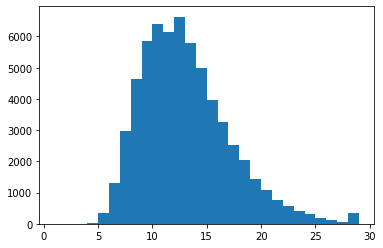

In [6]:
sentenceLengths= [l for l in sentLengthList]

plt.hist(np.array(sentenceLengths), bins=(max_length-2))

In [7]:
numSentences = len(bertSentenceIDs)

nerClasses = pd.DataFrame(np.array(nerTokenList).reshape(-1))
nerClasses.columns = ['tag']
nerClasses.tag = pd.Categorical(nerClasses.tag)
nerClasses['cat'] = nerClasses.tag.cat.codes
nerClasses['sym'] = nerClasses.tag.cat.codes
nerLabels = np.array(nerClasses.cat).reshape(numSentences, -1)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7999dfb898>]],
      dtype=object)

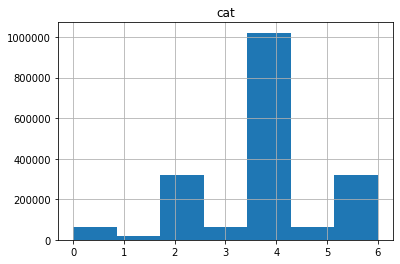

In [8]:
nerClasses[['cat']].hist(bins=7)

In [9]:
nerDistribution = (nerClasses.groupby(['tag', 'cat']).agg({'sym':'count'}).reset_index()
                   .rename(columns={'sym':'occurences'}))

numNerClasses = nerDistribution.tag.nunique()

nerDistribution

,tag,cat,occurences
0,B-B,0,62244
1,I-B,1,18692
2,O,2,319829
3,[nerCLS],3,62182
4,[nerPAD],4,1021680
5,[nerSEP],5,62182
6,nerX,6,318651


In [10]:
O_occurences = nerDistribution.loc[nerDistribution.tag == 'O','occurences']
All_occurences = nerDistribution[nerDistribution.cat < 3]['occurences'].sum()

O_occurences/All_occurences

2    0.798046
Name: occurences, dtype: float64

In [11]:
bert_inputs = np.array([bertSentenceIDs, bertMasks, bertSequenceIDs])

In [12]:
numSentences = len(bert_inputs[0])
np.random.seed(0)
training_examples = np.random.binomial(1, 0.7, numSentences)

In [13]:
trainSentence_ids = []
trainMasks = []
trainSequence_ids = []

testSentence_ids = []
testMasks = []
testSequence_ids = []

nerLabels_train =[]
nerLabels_test = []


for example in range(numSentences):
    if training_examples[example] == 1:
        trainSentence_ids.append(bert_inputs[0][example])
        trainMasks.append(bert_inputs[1][example])
        trainSequence_ids.append(bert_inputs[2][example])
        nerLabels_train.append(nerLabels[example])
    else:
        testSentence_ids.append(bert_inputs[0][example])
        testMasks.append(bert_inputs[1][example])
        testSequence_ids.append(bert_inputs[2][example])
        nerLabels_test.append(nerLabels[example])
        
X_train = np.array([trainSentence_ids,trainMasks,trainSequence_ids])
X_test = np.array([testSentence_ids,testMasks,testSequence_ids])

nerLabels_train = np.array(nerLabels_train)
nerLabels_test = np.array(nerLabels_test)

In [14]:
# Use a parameter pair k_start, k_end to look at slices. This helps with quick tests.

k_start = 0
k_end = -1

if k_end == -1:
    k_end_train = X_train[0].shape[0]
    k_end_test = X_test[0].shape[0]
else:
    k_end_train = k_end_test = k_end
    


bert_inputs_train_k = [X_train[0][k_start:k_end_train], X_train[1][k_start:k_end_train], 
                       X_train[2][k_start:k_end_train]]
bert_inputs_test_k = [X_test[0][k_start:k_end_test], X_test[1][k_start:k_end_test], 
                      X_test[2][k_start:k_end_test]]


labels_train_k = nerLabels_train[k_start:k_end_train]
labels_test_k = nerLabels_test[k_start:k_end_test]

In [15]:
def custom_loss(y_true, y_pred):
    """
    calculate loss function explicitly, filtering out 'extra inserted labels'
    
    y_true: Shape: (batch x (max_length + 1) )
    y_pred: predictions. Shape: (batch x x (max_length + 1) x num_distinct_ner_tokens ) 
    
    returns:  cost
    """

    #get labels and predictions
    
    y_label = tf.reshape(tf.layers.Flatten()(tf.cast(y_true, tf.int32)),[-1])
    
    mask = (y_label < 3)   # This mask is used to remove all tokens that do not correspond to the original base text.

    y_label_masked = tf.boolean_mask(y_label, mask)  # mask the labels
    
    y_flat_pred = tf.reshape(tf.layers.Flatten()(tf.cast(y_pred, tf.float32)),[-1, numNerClasses])
    
    y_flat_pred_masked = tf.boolean_mask(y_flat_pred, mask) # mask the predictions
    
    return tf.reduce_mean(sparse_categorical_crossentropy(y_label_masked, y_flat_pred_masked,from_logits=False ))

In [16]:
def custom_acc_orig_tokens(y_true, y_pred):
    """
    calculate loss dfunction filtering out also the newly inserted labels
    
    y_true: Shape: (batch x (max_length) )
    y_pred: predictions. Shape: (batch x x (max_length + 1) x num_distinct_ner_tokens ) 
    
    returns: accuracy
    """

    #get labels and predictions
    
    y_label = tf.reshape(tf.layers.Flatten()(tf.cast(y_true, tf.int64)),[-1])
    
    mask = (y_label < 3)
    y_label_masked = tf.boolean_mask(y_label, mask)
    
    y_predicted = tf.math.argmax(input = tf.reshape(tf.layers.Flatten()(tf.cast(y_pred, tf.float64)),\
                                                    [-1, numNerClasses]), axis=1)
    
    y_predicted_masked = tf.boolean_mask(y_predicted, mask)

    return tf.reduce_mean(tf.cast(tf.equal(y_predicted_masked,y_label_masked) , dtype=tf.float64))

In [17]:
def custom_acc_orig_non_other_tokens(y_true, y_pred):
    """
    calculate loss dfunction explicitly filtering out also the 'Other'- labels
    
    y_true: Shape: (batch x (max_length) )
    y_pred: predictions. Shape: (batch x x (max_length + 1) x num_distinct_ner_tokens ) 
    
    returns: accuracy
    """

    #get labels and predictions
    
    y_label = tf.reshape(tf.layers.Flatten()(tf.cast(y_true, tf.int64)),[-1])
    
    mask = (y_label < 2)
    y_label_masked = tf.boolean_mask(y_label, mask)
    
    y_predicted = tf.math.argmax(input = tf.reshape(tf.layers.Flatten()(tf.cast(y_pred, tf.float64)),\
                                                    [-1, numNerClasses]), axis=1)
    
    y_predicted_masked = tf.boolean_mask(y_predicted, mask)

    return tf.reduce_mean(tf.cast(tf.equal(y_predicted_masked,y_label_masked) , dtype=tf.float64))

In [18]:
adam_customized = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.91, beta_2=0.999, epsilon=None, decay=0.1, amsgrad=False)

In [19]:
class BertLayer(tf.keras.layers.Layer):
    """
    Create BERT layer, following https://towardsdatascience.com/bert-in-keras-with-tensorflow-hub-76bcbc9417b
    init:  initialize layer. Specify various parameters regarding output types and dimensions. Very important is
           to set the number of trainable layers.
    build: build the layer based on parameters
    call:  call the BERT layer within a model
    """
    
    def __init__(
        self,
        n_fine_tune_layers=10,
        pooling="sequence",
        bert_url="https://tfhub.dev/google/bert_multi_cased_L-12_H-768_A-12/1",
        **kwargs,
    ):
        self.n_fine_tune_layers = n_fine_tune_layers
        self.trainable = True
        self.output_size = 768
        self.pooling = pooling
        self.bert_url = bert_url

        super(BertLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.bert = hub.Module(
            self.bert_url, trainable=self.trainable, name=f"{self.name}_module"
        )

        # Remove unused layers
        trainable_vars = self.bert.variables
        trainable_vars = [
                var
                for var in trainable_vars
                if not "/cls/" in var.name and not "/pooler/" in var.name
            ]
        trainable_layers = []


        # Select how many layers to fine tune
        for i in range(self.n_fine_tune_layers):
            trainable_layers.append(f"encoder/layer_{str(11 - i)}")

        # Update trainable vars to contain only the specified layers
        trainable_vars = [
            var
            for var in trainable_vars
            if any([l in var.name for l in trainable_layers])
        ]

        # Add to trainable weights
        for var in trainable_vars:
            self._trainable_weights.append(var)

        for var in self.bert.variables:
            if var not in self._trainable_weights:
                self._non_trainable_weights.append(var)

        super(BertLayer, self).build(input_shape)

    def call(self, inputs):
        inputs = [K.cast(x, dtype="int32") for x in inputs]
        input_ids, input_mask, segment_ids = inputs
        bert_inputs = dict(
            input_ids=input_ids, input_mask=input_mask, segment_ids=segment_ids
        )
        result = self.bert(inputs=bert_inputs, signature="tokens", as_dict=True)[
                "sequence_output"
            ]

        mul_mask = lambda x, m: x * tf.expand_dims(m, axis=-1)

        return result

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_size)

In [20]:
def variable_summaries(var):
    """Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)

In [21]:
def ner_model(max_input_length, train_layers, optimizer):
    """
    Implementation of NER model
    
    variables:
        max_input_length: number of tokens (max_length + 1)
        train_layers: number of layers to be retrained
        optimizer: optimizer to be used
    
    returns: model
    """
    
    in_id = tf.keras.layers.Input(shape=(max_input_length,), name="input_ids")
    in_mask = tf.keras.layers.Input(shape=(max_input_length,), name="input_masks")
    in_segment = tf.keras.layers.Input(shape=(max_input_length,), name="segment_ids")
    
    
    bert_inputs = [in_id, in_mask, in_segment]
    
    bert_sequence = BertLayer(n_fine_tune_layers=train_layers)(bert_inputs)
    
    #print(bert_sequence)
    
    lstm = Bidirectional(LSTM(256, return_sequences=True))(bert_sequence)
    
    dense = TimeDistributed(Dense(256, activation='relu'))(lstm)
    
    dense = Dropout(rate=0.1)(dense)
    
    dense = tf.keras.layers.Dropout(rate=0.1)(dense)
    
    pred = tf.keras.layers.Dense(7, activation='softmax', name='ner')(dense)
     
    print('pred: ', pred)
    
    ## Prepare for multipe loss functions, although not used here
    
    losses = {
        "ner": custom_loss,
        }
    lossWeights = {"ner": 1.0
                  }
    
    model = tf.keras.models.Model(inputs=bert_inputs, outputs=pred)

    model.compile(loss=losses, optimizer=optimizer, metrics=[custom_acc_orig_tokens, 
                                                          custom_acc_orig_non_other_tokens])
    
    
    model.summary()
    
    return model

def initialize_vars(sess):
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    K.set_session(sess)

In [22]:
numTrainSentences = 1000
validation_split = 0.5
np.random.seed(seed=0)
indices = np.arange(bert_inputs_train_k[0].shape[0])
np.random.shuffle(indices)

bert_inputs_train_reordered = [bert_inputs_train_k[0][indices], \
                          bert_inputs_train_k[1][indices], \
                          bert_inputs_train_k[2][indices]]

labels_train_reordered = labels_train_k[indices]

nb_validation_samples = int(validation_split * numTrainSentences)

end_validation_samples = int(nb_validation_samples+numTrainSentences*(1-validation_split))

bert_inputs_train_tiny = [bert_inputs_train_reordered[0][:nb_validation_samples], \
                          bert_inputs_train_reordered[1][:nb_validation_samples], \
                          bert_inputs_train_reordered[2][:nb_validation_samples]]

bert_inputs_validate_tiny = [bert_inputs_train_reordered[0][nb_validation_samples:end_validation_samples], \
                          bert_inputs_train_reordered[1][nb_validation_samples:end_validation_samples], \
                          bert_inputs_train_reordered[2][nb_validation_samples:end_validation_samples]]


y_train = labels_train_reordered[:nb_validation_samples]
#x_val = data[-nb_validation_samples:]
y_val = labels_train_reordered[nb_validation_samples:end_validation_samples]

In [23]:
sess = tf.Session()

model = ner_model(max_length,train_layers=0,optimizer='adam')

# Instantiate variables
initialize_vars(sess)

tensorboard = TensorBoard(log_dir="logs/{}".format(time()))

model.fit(
    bert_inputs_train_tiny, 
    {"ner": y_train },
    validation_data=(bert_inputs_validate_tiny, {"ner": y_val}),
    epochs=8,
    batch_size=32#,
    #callbacks=[tensorboard]
)

W0806 21:32:42.835906 140166838814528 deprecation.py:506] From /home/felipe/.local/share/virtualenvs/w266_final_project-K7oLnwuw/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0806 21:32:42.842859 140166838814528 deprecation.py:506] From /home/felipe/.local/share/virtualenvs/w266_final_project-K7oLnwuw/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0806 21:32:42.844242 140166838814528 deprecation.py:506] From /home/felipe/.local/share/virtualenvs

pred:  Tensor("ner/truediv:0", shape=(?, ?, 7), dtype=float32)


W0806 21:32:43.679526 140166838814528 deprecation.py:323] From /home/felipe/.local/share/virtualenvs/w266_final_project-K7oLnwuw/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py:1354: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 30)]         0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 30)]         0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 30)]         0                                            
__________________________________________________________________________________________________
bert_layer (BertLayer)          (None, None, 768)    178565115   input_ids[0][0]                  
                                                                 input_masks[0][0]            

In [24]:
bert_inputs_infer = [X_test[0], X_test[1], X_test[2]]

result = model.predict(
    bert_inputs_infer, 
    batch_size=32
)

In [25]:
predictions_flat = [pred for preds in np.argmax(result, axis=2) for pred in preds]
labels_flat = [label for labels in nerLabels_test for label in labels]

clean_preds = []
clean_labels = []

for pred, label in zip(predictions_flat, labels_flat):
    if label < 3:
        clean_preds.append(pred)
        clean_labels.append(label)

In [26]:
from sklearn.metrics import classification_report

In [27]:
target_names = list(nerDistribution['tag'])[0:3]

In [28]:
print(classification_report(clean_labels, clean_preds, target_names=target_names, digits=3))

              precision    recall  f1-score   support

         B-B      0.766     0.721     0.743     18579
         I-B      0.918     0.483     0.633      5637
           O      0.929     0.965     0.947     95368

    accuracy                          0.905    119584
   macro avg      0.871     0.723     0.774    119584
weighted avg      0.903     0.905     0.900    119584

